In [1]:
%matplotlib inline
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf
import numpy as np
import librosa
from utils.strechableNumpyArray import StrechableNumpyArray
import matplotlib.pyplot as plt
import IPython
import functools
from tensorflow.contrib.signal.python.ops import window_ops

In [2]:
tf.reset_default_graph()

import pickle

from architecture.contextEncoderArchitecture import ContextEncoderArchitecture
from system.contextEncoderSystem import ContextEncoderSystem
from system.preAndPostProcessor import PreAndPostProcessor

architecturesParametersFile = "Papers_Context_Encoder_parameters.pkl"
sessionsName = "Papers_Context_Encoder"

with open(architecturesParametersFile, 'rb') as savedFile:
    Context_Encoder_parameters = pickle.load(savedFile)

aContextEncoderArchitecture = ContextEncoderArchitecture(*Context_Encoder_parameters.architectureParameters())
aPreProcessor = PreAndPostProcessor(*Context_Encoder_parameters.preProcessorParameters())
aContextEncoderSystem = ContextEncoderSystem(aContextEncoderArchitecture, Context_Encoder_parameters.batchSize(),
                                             aPreProcessor, sessionsName)


---------
Encoder
---------
Tensor("ContextEncoderArchitecture/input_data:0", shape=(256, 16, 257, 4), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Conv_0/Conv2D:0", shape=(256, 8, 129, 32), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Relu:0", shape=(256, 8, 129, 32), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/batch_normalization/cond/Merge:0", shape=(256, 8, 129, 32), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Conv_1/Conv2D:0", shape=(256, 4, 43, 128), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Relu_1:0", shape=(256, 4, 43, 128), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/batch_normalization_1/cond/Merge:0", shape=(256, 4, 43, 128), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Conv_2/Conv2D:0", shape=(256, 2, 15, 512), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/Relu_2:0", shape=(256, 2, 15, 512), dtype=float32)
Tensor("ContextEncoderArchitecture/Encoder/batch_normalizatio

In [3]:
sr = 16000
start_in_seconds = 0.1
gap_length = 1024
side_length = 2048

starting_sample_left_side = int(sr*start_in_seconds)
ending_sample_left_side = starting_sample_left_side + side_length
starting_sample_right_side = ending_sample_left_side + gap_length
ending_sample_right_side = starting_sample_right_side + side_length

best_step = 632000
batch_size = 64

In [37]:
pathToDatasetFolder = "../LSTMsOnSpectrograms/nsynth-test/audio"
audios = StrechableNumpyArray()
i = 0
total = 0
file_names = []
for file_name in os.listdir(pathToDatasetFolder):
    audio, sr = librosa.load(pathToDatasetFolder + '/' + file_name, sr=None)

    if np.sum(np.absolute(audio[5120:5120*2])) < 5120*1e-3: 
        print(file_name, "doesn't meet the minimum amplitude requirement")
        continue

    file_names.append(file_name)
    audios.append(audio)
    i+=1

    if i > 500:
        i -= 500
        total += 500
        print("500 plus!", total)
#         if total >= 0 and i >= 8:
#             break
print("there were: ", total+i)

audios = audios.finalize()
audios = np.reshape(audios, (total+i, len(audio)))
print(audios.shape)

bass_electronic_018-022-100.wav doesn't meet the minimum amplitude requirement
bass_electronic_018-023-025.wav doesn't meet the minimum amplitude requirement
bass_electronic_025-022-050.wav doesn't meet the minimum amplitude requirement
bass_electronic_027-022-050.wav doesn't meet the minimum amplitude requirement
500 plus! 500
bass_synthetic_134-080-127.wav doesn't meet the minimum amplitude requirement
bass_synthetic_134-083-100.wav doesn't meet the minimum amplitude requirement
bass_synthetic_134-086-050.wav doesn't meet the minimum amplitude requirement
bass_synthetic_134-091-075.wav doesn't meet the minimum amplitude requirement
bass_synthetic_134-092-050.wav doesn't meet the minimum amplitude requirement
bass_synthetic_134-093-075.wav doesn't meet the minimum amplitude requirement
bass_synthetic_134-093-100.wav doesn't meet the minimum amplitude requirement
bass_synthetic_134-095-075.wav doesn't meet the minimum amplitude requirement
bass_synthetic_134-095-100.wav doesn't meet th

500 plus! 2000
keyboard_electronic_002-103-050.wav doesn't meet the minimum amplitude requirement
keyboard_electronic_002-104-025.wav doesn't meet the minimum amplitude requirement
keyboard_electronic_002-105-050.wav doesn't meet the minimum amplitude requirement
keyboard_electronic_002-105-100.wav doesn't meet the minimum amplitude requirement
keyboard_electronic_002-106-100.wav doesn't meet the minimum amplitude requirement
keyboard_electronic_002-108-050.wav doesn't meet the minimum amplitude requirement
keyboard_electronic_098-108-100.wav doesn't meet the minimum amplitude requirement
500 plus! 2500
keyboard_synthetic_000-104-127.wav doesn't meet the minimum amplitude requirement
keyboard_synthetic_000-107-075.wav doesn't meet the minimum amplitude requirement
keyboard_synthetic_000-108-050.wav doesn't meet the minimum amplitude requirement
mallet_acoustic_056-033-100.wav doesn't meet the minimum amplitude requirement
mallet_acoustic_056-035-025.wav doesn't meet the minimum amplitu

In [38]:
original_signals = audios[:, starting_sample_left_side:ending_sample_right_side]
original_gaps = audios[:, ending_sample_left_side:starting_sample_right_side]

In [39]:
generatedSpecs = aContextEncoderSystem.reconstructAudio(original_signals, model_num=best_step)

INFO:tensorflow:Restoring parameters from utils/saved_models/Papers_Context_Encoder/model-Papers_Context_Encoder632000.ckpt
Model restored.


In [40]:
complexGenerated = generatedSpecs[0][:, :, :, 0] + 1.0j * generatedSpecs[0][:, :, :, 1]
complexOriginal = generatedSpecs[1][:, :, :, 0] + 1.0j * generatedSpecs[1][:, :, :, 1]
complexContext = np.concatenate([generatedSpecs[2][:, :, :, 0] + 1.0j * generatedSpecs[2][:, :, :, 1],
                                 generatedSpecs[2][:, :, :, 2] + 1.0j * generatedSpecs[2][:, :, :, 3]],
                                axis=1)

print(complexContext.shape)
print(complexGenerated.shape)
print(generatedSpecs[0].shape)


(3840, 32, 257)
(3840, 11, 257)
(3840, 11, 257, 2)


In [60]:
print(np.mean(_pavlovs_SNR(np.maximum(np.abs(complexGenerated), 1e-2), np.abs(complexOriginal), onAxis=(1, 2))))
np.sum(np.square(generatedSpecs[0]-generatedSpecs[1]))
print(np.max(generatedSpecs[0]))
print(np.max(generatedSpecs[1]))
print(np.min(generatedSpecs[0]))
print(np.min(generatedSpecs[1]))

16.62614
238.991
238.29144
-124.924034
-137.44472


In [25]:
Context_Encoder_parameters.contextStftFrameCount()

16

c:\users\andres\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


max 2.379569956155769
33.42298746109009


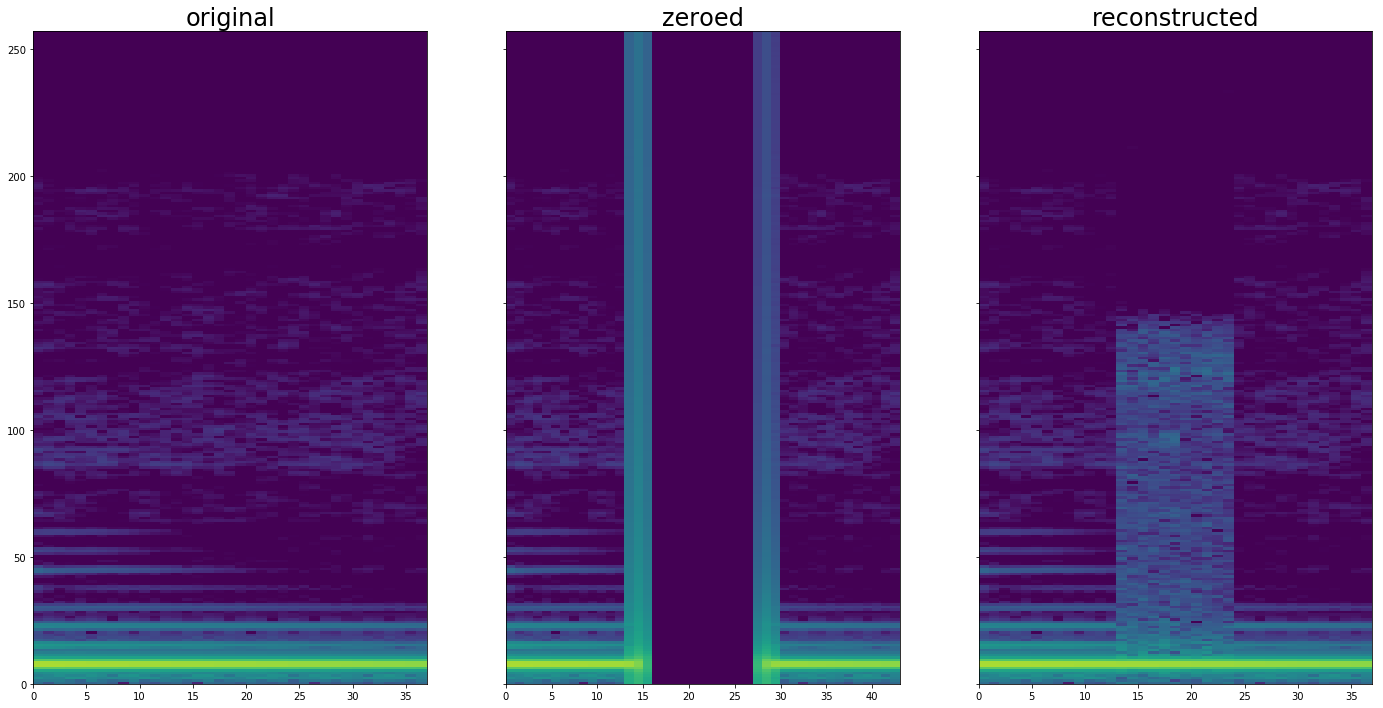

In [45]:
testOn = 150
import pylab
pylab.rcParams['figure.figsize'] = (14, 8)
f, axarr = plt.subplots(1, 3, sharey='row', figsize=(24, 12))

#scaleeee
z_max = np.max(np.log10(np.abs(complexContext)))
z_min = -3
print('max', z_max)

originalPlot = np.concatenate([complexContext[testOn, :int(Context_Encoder_parameters.contextStftFrameCount())-3], 
                         complexOriginal[testOn],
                         complexContext[testOn, 3+int(Context_Encoder_parameters.contextStftFrameCount()):]], 
                        axis=0)+1e-10
zeroedPlot = np.concatenate([complexContext[testOn, :int(Context_Encoder_parameters.contextStftFrameCount())], 
                         np.zeros(complexOriginal[0].shape)+1e-10,
                         complexContext[testOn, int(Context_Encoder_parameters.contextStftFrameCount()):]], 
                        axis=0)+1e-10
reconstructedPlot = np.concatenate([complexContext[testOn, :int(Context_Encoder_parameters.contextStftFrameCount())-3], 
                         complexGenerated[testOn],
                         complexContext[testOn, 3+int(Context_Encoder_parameters.contextStftFrameCount()):]], 
                        axis=0)+1e-10

axarr[0].pcolormesh(np.log10(np.abs(originalPlot)).transpose(), vmin=z_min, vmax=z_max)
axarr[0].set_title('original', size=24)
axarr[1].pcolormesh(np.log10(np.abs(zeroedPlot)).transpose(), vmin=z_min, vmax=z_max)
axarr[1].set_title('zeroed', size=24)
axarr[2].pcolormesh(np.log10(np.abs(reconstructedPlot)).transpose(), vmin=z_min, vmax=z_max)
axarr[2].set_title('reconstructed', size=24);

plt.savefig('test.png')

print(_pavlovs_SNR(generatedTimeSignals[testOn], originalTimeSignals[testOn], onAxis=(0)))

Text(0.5,1,'reconstructed')

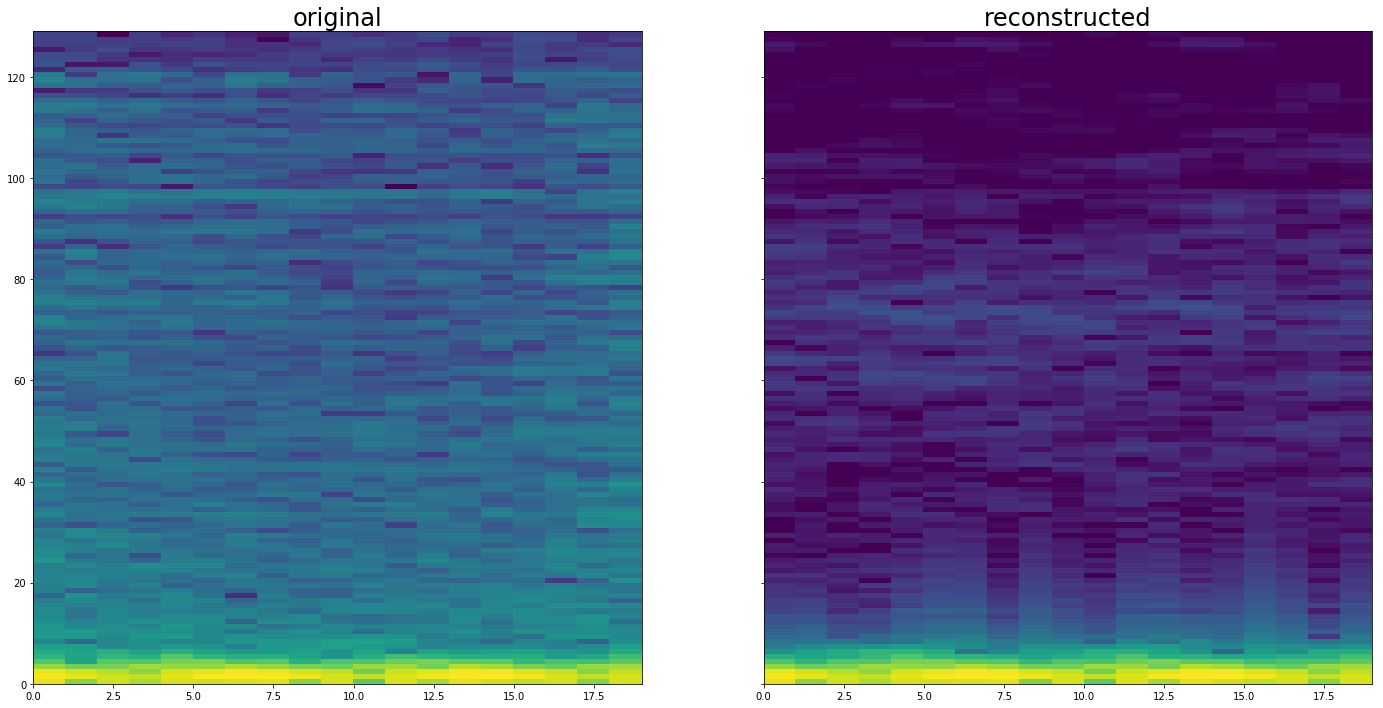

In [446]:
# testOn = 25

f, axarr = plt.subplots(1, 2, sharey='row', figsize=(24, 12))

#scaleeee
z_max = np.max(np.log10(np.abs(complexGenerated[testOn])))
z_min = np.min(np.log10(np.abs(complexGenerated[testOn])))


axarr[0].pcolormesh(np.log10(np.abs(complexGenerated[testOn]).transpose()), vmin=z_min, vmax=z_max)
axarr[0].set_title('original', size=24)
axarr[1].pcolormesh(np.log10(np.abs(complexOriginal[testOn]).transpose()), vmin=z_min, vmax=z_max)
axarr[1].set_title('reconstructed', size=24)


In [249]:
complexWithOriginalPhase = np.abs(complexGenerated) * np.exp(1.0j * np.angle(complexOriginal))

with tf.Session() as sess:
    originalPhaseTimeSignals = sess.run(tf_inverse_stft, feed_dict={stft_to_invert: complexWithOriginalPhase})


In [14]:
window_fn = functools.partial(window_ops.hann_window, periodic=True)
inverse_window = tf.contrib.signal.inverse_stft_window_fn(Context_Encoder_parameters.fftHopSize(),
                                       forward_window_fn=window_fn)
stft_to_invert = tf.placeholder(tf.complex64, shape=complexGenerated.shape, name='stft_to_invert')
tf_inverse_stft = tf.contrib.signal.inverse_stft(stfts=stft_to_invert, frame_length=Context_Encoder_parameters.fftWindowLength(), 
                                                          frame_step=Context_Encoder_parameters.fftHopSize(), window_fn=inverse_window)
with tf.Session() as sess:
    generatedTimeSignals = sess.run(tf_inverse_stft, feed_dict={stft_to_invert: complexGenerated})
    originalTimeSignals = sess.run(tf_inverse_stft, feed_dict={stft_to_invert: complexOriginal})

    

In [15]:
generatedTimeSignals.shape

(256, 1792)

In [16]:
reconstructedSignals = np.concatenate([audios[:len(generatedTimeSignals), :ending_sample_left_side], generatedTimeSignals[:, 384:-384], audios[:len(generatedTimeSignals), starting_sample_right_side:]], axis=1)
rec_original_signals = np.concatenate([audios[:len(generatedTimeSignals), :ending_sample_left_side], originalTimeSignals[:, 384:-384], audios[:len(generatedTimeSignals), starting_sample_right_side:]], axis=1)
# recPhase = np.concatenate([audios[:len(generatedTimeSignals), :ending_sample_left_side], originalPhaseTimeSignals[:, params.padding():-params.padding()], audios[:len(generatedTimeSignals), starting_sample_right_side:]], axis=1)

zeroedSignals = np.concatenate([audios[:len(generatedTimeSignals), :ending_sample_left_side], np.zeros([len(generatedTimeSignals), 1024], dtype=np.float32), audios[:len(generatedTimeSignals), starting_sample_right_side:]], axis=1)

In [16]:
reconstructedSignals.shape

(256, 64000)

In [127]:
sr

16000

In [20]:
testOn = 200

print(_pavlovs_SNR(generatedTimeSignals[testOn], originalTimeSignals[testOn], onAxis=(0)))

# IPython.display.Audio(data=recPhase[testOn], rate=16000)

# librosa.output.write_wav("original_context.wav", rec_original_signals[testOn], sr)
# librosa.output.write_wav("zeroed_context.wav", zeroedSignals[testOn], sr)
# librosa.output.write_wav("generated_context.wav", reconstructedSignals[testOn], sr)

IPython.display.Audio(data=rec_original_signals[testOn], rate=16000)
# IPython.display.Audio(data=zeroedSignals[testOn], rate=16000)
# IPython.display.Audio(data=reconstructedSignals[testOn], rate=16000)

9.305733442306519


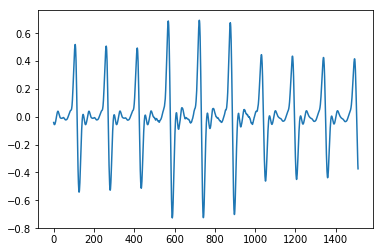

In [34]:
plt.plot(reconstructedSignals[testOn,ending_sample_left_side-500:starting_sample_right_side+500])

28.51715087890625


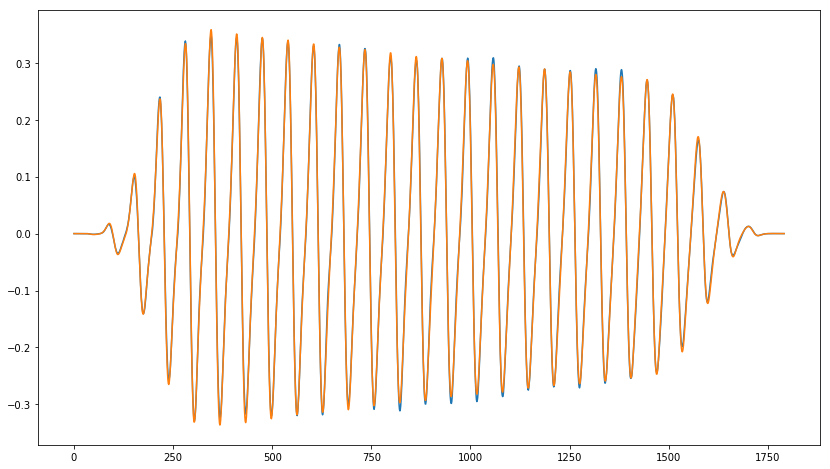

In [25]:
plt.plot(generatedTimeSignals[testOn, :])
plt.plot(originalTimeSignals[testOn, :])
# plt.plot(originalPhaseTimeSignals[testOn, 1230:1250])
print(_pavlovs_SNR(generatedTimeSignals[testOn], originalTimeSignals[testOn], onAxis=(0)))
# print(_pavlovs_SNR(originalPhaseTimeSignals[testOn], originalTimeSignals[testOn], onAxis=(0)))

28.51715087890625


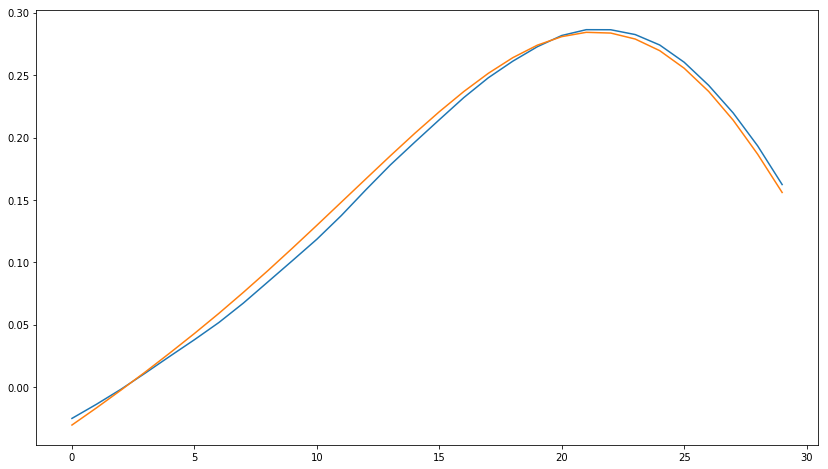

In [26]:
plt.plot(generatedTimeSignals[testOn, 1230:1260])
plt.plot(originalTimeSignals[testOn, 1230:1260])
print(_pavlovs_SNR(generatedTimeSignals[testOn], originalTimeSignals[testOn], onAxis=(0)))


In [202]:
generatedSpecs[0][10]==generatedSpecs[1][10]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [18]:
def _pavlovs_SNR(y_orig, y_inp, onAxis=(1,)):
    norm_y_orig = _squaredEuclideanNorm(y_orig, onAxis)
    norm_y_orig_minus_y_inp = _squaredEuclideanNorm(y_orig - y_inp, onAxis)
    return 10 * np.log10(norm_y_orig / norm_y_orig_minus_y_inp)

def _squaredEuclideanNorm(vector, onAxis=(1,)):
    squared = np.square(vector)
    summed = np.sum(squared, axis=onAxis)
    return summed

SNRs = _pavlovs_SNR(originalTimeSignals, generatedTimeSignals, onAxis=(1,))
print(np.mean(SNRs))
print(np.std(SNRs))
print(np.max(SNRs))
print(np.min(SNRs))


19.9137
9.806878
33.46729
0.022368347


In [487]:
SNRs = _pavlovs_SNR(originalTimeSignals, generatedTimeSignals, onAxis=(1,))
print(np.mean(SNRs))
print(np.std(SNRs))
print(np.max(SNRs))
print(np.min(SNRs))


5.956699
2.304683
22.789444
-5.8636456


In [296]:
np.where(SNRs<10)

(array([ 156,  157,  158, ..., 3901, 3902, 3903], dtype=int64),)

In [47]:
pSNRs = _pavlovs_SNR(originalPhaseTimeSignals, originalTimeSignals, onAxis=(1,))
print(np.mean(pSNRs))



14.469685


In [295]:
print(np.mean(_pavlovs_SNR(generatedTimeSignals[1000:], originalTimeSignals[1000:], onAxis=(1,))))


14.006761


c:\users\andres\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


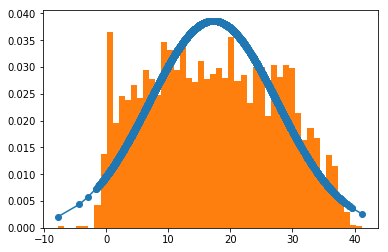

In [454]:
sorted_SNR = sorted(SNRs)

import scipy.stats as stats
fit = stats.norm.pdf(sorted_SNR, np.mean(sorted_SNR), np.std(sorted_SNR))  #this is a fitting indeed

plt.plot(sorted_SNR,fit,'-o')

plt.hist(sorted_SNR, 50, normed=True)    ;

c:\users\andres\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


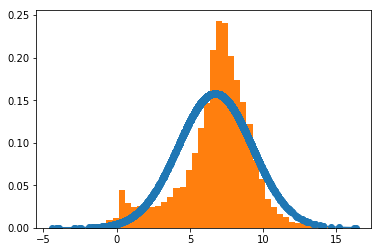

In [334]:
sorted_SNR = sorted(SNRs)

import scipy.stats as stats
fit = stats.norm.pdf(sorted_SNR, np.mean(sorted_SNR), np.std(sorted_SNR))  #this is a fitting indeed

plt.plot(sorted_SNR,fit,'-o')

plt.hist(sorted_SNR, 50, normed=True);   

In [33]:
print(np.where(SNRs<-10))

(array([ 255,  256,  257,  260,  271,  709,  945,  961,  963,  964,  971,
        979,  980,  981, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020,
       1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031,
       1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042,
       1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053,
       1949, 1952, 2036, 2039, 2040, 2042, 2043, 2045, 2047, 2048, 2633,
       2634, 2637, 2638, 2639, 2640, 2943, 2944, 2945, 2946, 2948, 2949,
       2950, 2951, 2952, 2953, 3438, 3439, 3451, 3452, 3453, 3454, 3851,
       3852, 3859, 3860, 3861, 3863, 3865, 3870, 3874, 3877, 3879, 3881,
       3882, 3885, 3886, 3889, 3890, 3894, 3895, 3896, 3897, 3901],
      dtype=int64),)


In [ ]:
import copy
def griffinLim(stfts, passes, params):
    absolute_values = np.abs(stfts)
    window_fn = functools.partial(window_ops.hann_window, periodic=True)
    inverse_window = tf.contrib.signal.inverse_stft_window_fn(params.fftHopSize(),
                                           forward_window_fn=window_fn)
    stft_to_invert = tf.placeholder(tf.complex64, shape=realSignals.shape, name='stft_to_invert')
    tf_inverse_stft = tf.contrib.signal.inverse_stft(stfts=stft_to_invert, frame_length=params.fftWindowLength(), 
                                                              frame_step=params.fftHopSize(), window_fn=inverse_window)
    tf_forward_stft = tf.contrib.signal.stft(signals=tf_inverse_stft, frame_length=params.fftWindowLength(), 
                                          frame_step=params.fftHopSize(), window_fn=window_fn)
    with tf.Session() as sess:
        for i in range(passes):
            realSignals = absolute_values + 1.0j*np.imag(realSignals)
            feed_dict = {stft_to_invert: realSignals}
            realSignals = sess.run(tf_forward_stft, feed_dict=feed_dict)
        feed_dict = {stft_to_invert: realSignals}
        return sess.run(tf_inverse_stft, feed_dict=feed_dict)